In [36]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras import regularizers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import set_random_seed
from numpy.random import seed

import pandas_datareader.data as web

from pandas_datareader import data as web
from pandas_datareader.google.daily import GoogleDailyReader

import datetime as dt
from IPython.display import display, HTML

import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [2]:
#set seeds
seed(1)
set_random_seed(2)

## Retrieve Data through Web Scraping

In [5]:
# web scrap from 1/1/2016 to the most recent day for every stock
stockNames = ['AMZN', 'ANSS', 'WMT', 'GOOG', 'FB', 'EPAM', 'BLKB', 'BABA', 'AAPL']

def get_stock(stock, start, end):
    return web.get_data_yahoo(stock, start, end)['Close']

stocks = []

#first stock is the target stock
for stock in stockNames:
    stocks.append(DataFrame(get_stock(stock, dt.datetime(2016, 1, 1), dt.datetime(2017, 11, 5))))

## Data Pre-Processing

We did a windowing since this a time series analysis and windowing can improve the outcome of the model training.

In [6]:
#size of window
num_lags = 1
#keep scalers to rescale back later
scalers = list()
#colnames to update df after windowing
colNames = list()

df = DataFrame()

for i in range(0, len(stocks)):
    # get difference between day 0 closing and day -1 closing
    stock = stocks[i] - stocks[i].shift()
    stock = stock.iloc[1:,:]
    
    #define scale to scale by
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(stock)
    scalers.append(scaler)
    
    if i == 0:
        #add the difference of target stock without lags
        df = concat([df, DataFrame(scaler.transform(stock))], axis = 1)
        colNames.append(stockNames[i]+"_0")
    
    for lag in range(1, num_lags+1):
        #windowing of size num_lags
        tmp = stock.shift(lag)
        tmp.fillna(0, inplace=True)
        tmp = DataFrame(scaler.transform(tmp))
        df = concat([df, tmp], axis = 1)
        colNames.append(stockNames[i]+"_"+str(lag))
        
#add correct names
df.columns = colNames
#add date index 
df.index = stocks[0].index[1:]

df.tail()

,AMZN_0,AMZN_1,ANSS_1,WMT_1,GOOG_1,FB_1,EPAM_1,BLKB_1,BABA_1,AAPL_1
Date,,,,,,,,,,
2017-10-30,-0.341324,1.000000,-0.091621,-0.337448,1.000000,0.336319,0.037622,0.615010,0.139009,0.748031
2017-10-31,-0.516254,-0.341324,-0.279764,-0.495884,-0.122417,-0.134797,-0.015776,-0.314802,0.107328,0.465998
2017-11-01,-0.471363,-0.516254,-0.192552,-0.170781,-0.083601,-0.296014,-0.032767,-0.154968,-0.060594,0.272726
2017-11-02,-0.560243,-0.471363,-0.390495,-0.115224,0.130684,-0.080161,-0.101942,-0.492703,-0.228514,-0.367215
2017-11-03,-0.256742,-0.560243,1.000000,-0.067900,-0.070971,-0.648008,1.000000,-0.160529,-0.423366,0.115247


In [81]:
#define training and test size
training_size = int(len(df) * 0.7)

#split into training and test sets
training_set, test_set = df.iloc[:training_size, :], df.iloc[training_size:, :]    
#split each set into predictors and label
training_input, training_output = training_set.iloc[:, 1:].values, training_set.iloc[:, :1].values
test_input, test_output = test_set.iloc[:, 1:].values, test_set.iloc[:, :1].values
# add extra row into test_input to predict tomorrow's price
test_input = np.concatenate((test_input, test_set.iloc[-1:, :-1].values))
#reshape input of the LSTM to be format [samples, time steps, features]
training_input = training_input.reshape(training_input.shape[0], 1, training_input.shape[1])
test_input = test_input.reshape(test_input.shape[0], 1, test_input.shape[1])
#ensure that training_input is a multiple of batch_size
batch_size = 21
training_input_1 = training_input
training_output_1 = training_output
while (len(training_input_1) % batch_size != 0):
    training_input_1 = training_input_1[1:]
    training_output_1 = training_output_1[1:]
    
num_inputs = len(stocks) * num_lags

## Model Architecture and Training

Here we used LSTM from the Keras package as our model. Our activation function is relu and optimiser is Adam optimization. The Adam optimization algorithm update network weights iterative based in training data. This gives it an advantage over the classical stochastic gradient.

In [84]:
#define model
model = Sequential()
model.add(LSTM(30, batch_input_shape=(batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, return_sequences=True))
model.add(Activation('sigmoid'))
model.add(Dropout(0.2))
model.add(LSTM(20, stateful=True))
model.add(Activation('sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer=adam)

model.summary()

model.fit(x=training_input_1, y=training_output_1, epochs=500, batch_size=batch_size, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (21, 1, 30)               4800      
_________________________________________________________________
activation_75 (Activation)   (21, 1, 30)               0         
_________________________________________________________________
dropout_48 (Dropout)         (21, 1, 30)               0         
_________________________________________________________________
lstm_76 (LSTM)               (21, 20)                  4080      
_________________________________________________________________
activation_76 (Activation)   (21, 20)                  0         
_________________________________________________________________
dropout_49 (Dropout)         (21, 20)                  0         
_________________________________________________________________
dense_45 (Dense)             (21, 1)                   21        
Total para

315/315 [==============================] - 0s - loss: 0.0156     
Epoch 191/500
315/315 [==============================] - 0s - loss: 0.0154     
Epoch 192/500
315/315 [==============================] - 0s - loss: 0.0157     
Epoch 193/500
315/315 [==============================] - 0s - loss: 0.0158     
Epoch 194/500
315/315 [==============================] - 0s - loss: 0.0155     
Epoch 195/500
315/315 [==============================] - 0s - loss: 0.0154     
Epoch 196/500
315/315 [==============================] - 0s - loss: 0.0156     
Epoch 197/500
315/315 [==============================] - 0s - loss: 0.0152     
Epoch 198/500
315/315 [==============================] - 0s - loss: 0.0157     
Epoch 199/500
315/315 [==============================] - 0s - loss: 0.0155     
Epoch 200/500
315/315 [==============================] - 0s - loss: 0.0154     
Epoch 201/500
315/315 [==============================] - 0s - loss: 0.0153     
Epoch 202/500
315/315 [==============================]

315/315 [==============================] - 0s - loss: 0.0156     
Epoch 394/500
315/315 [==============================] - 0s - loss: 0.0154     
Epoch 395/500
315/315 [==============================] - 0s - loss: 0.0152     
Epoch 396/500
315/315 [==============================] - 0s - loss: 0.0157     
Epoch 397/500
315/315 [==============================] - 0s - loss: 0.0159     
Epoch 398/500
315/315 [==============================] - 0s - loss: 0.0155     
Epoch 399/500
315/315 [==============================] - 0s - loss: 0.0155     
Epoch 400/500
315/315 [==============================] - 0s - loss: 0.0154     
Epoch 401/500
315/315 [==============================] - 0s - loss: 0.0156     
Epoch 402/500
315/315 [==============================] - 0s - loss: 0.0155     
Epoch 403/500
315/315 [==============================] - 0s - loss: 0.0154     
Epoch 404/500
315/315 [==============================] - 0s - loss: 0.0156     
Epoch 405/500
315/315 [==============================]

## Training Outcome

In [92]:
#predict outcome using only batch size = 1
new_batch_size = 1
#get weights of trained model
weights = model.get_weights()
#build new model and set weights
new_model = Sequential()
new_model.add(LSTM(30, batch_input_shape=(new_batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, return_sequences=True))
new_model.add(Activation('sigmoid'))
new_model.add(Dropout(0.2))
new_model.add(LSTM(20, stateful=True))
new_model.add(Activation('sigmoid'))
new_model.add(Dropout(0.1))
new_model.add(Dense(1))
new_model.set_weights(weights)

adam = optimizers.Adam(lr=0.02)
new_model.compile(loss='mean_squared_error', optimizer=adam)

training_predictions = new_model.predict(training_input, batch_size=new_batch_size)
training_predictions = scalers[0].inverse_transform(training_predictions)

for i in range(len(training_input)):
    training_predictions[i][0] += stocks[0].iloc[i:i+1,:].values[0][0]
    
rmse = sqrt(mean_squared_error(stocks[0].iloc[:training_size, :].values, training_predictions))
print('Test RMSE: %.4f' % rmse+' (%.4f' % (rmse/test_predictions[-1][0]*100) +'%)')

Test RMSE: 3.1880 (0.2860%)


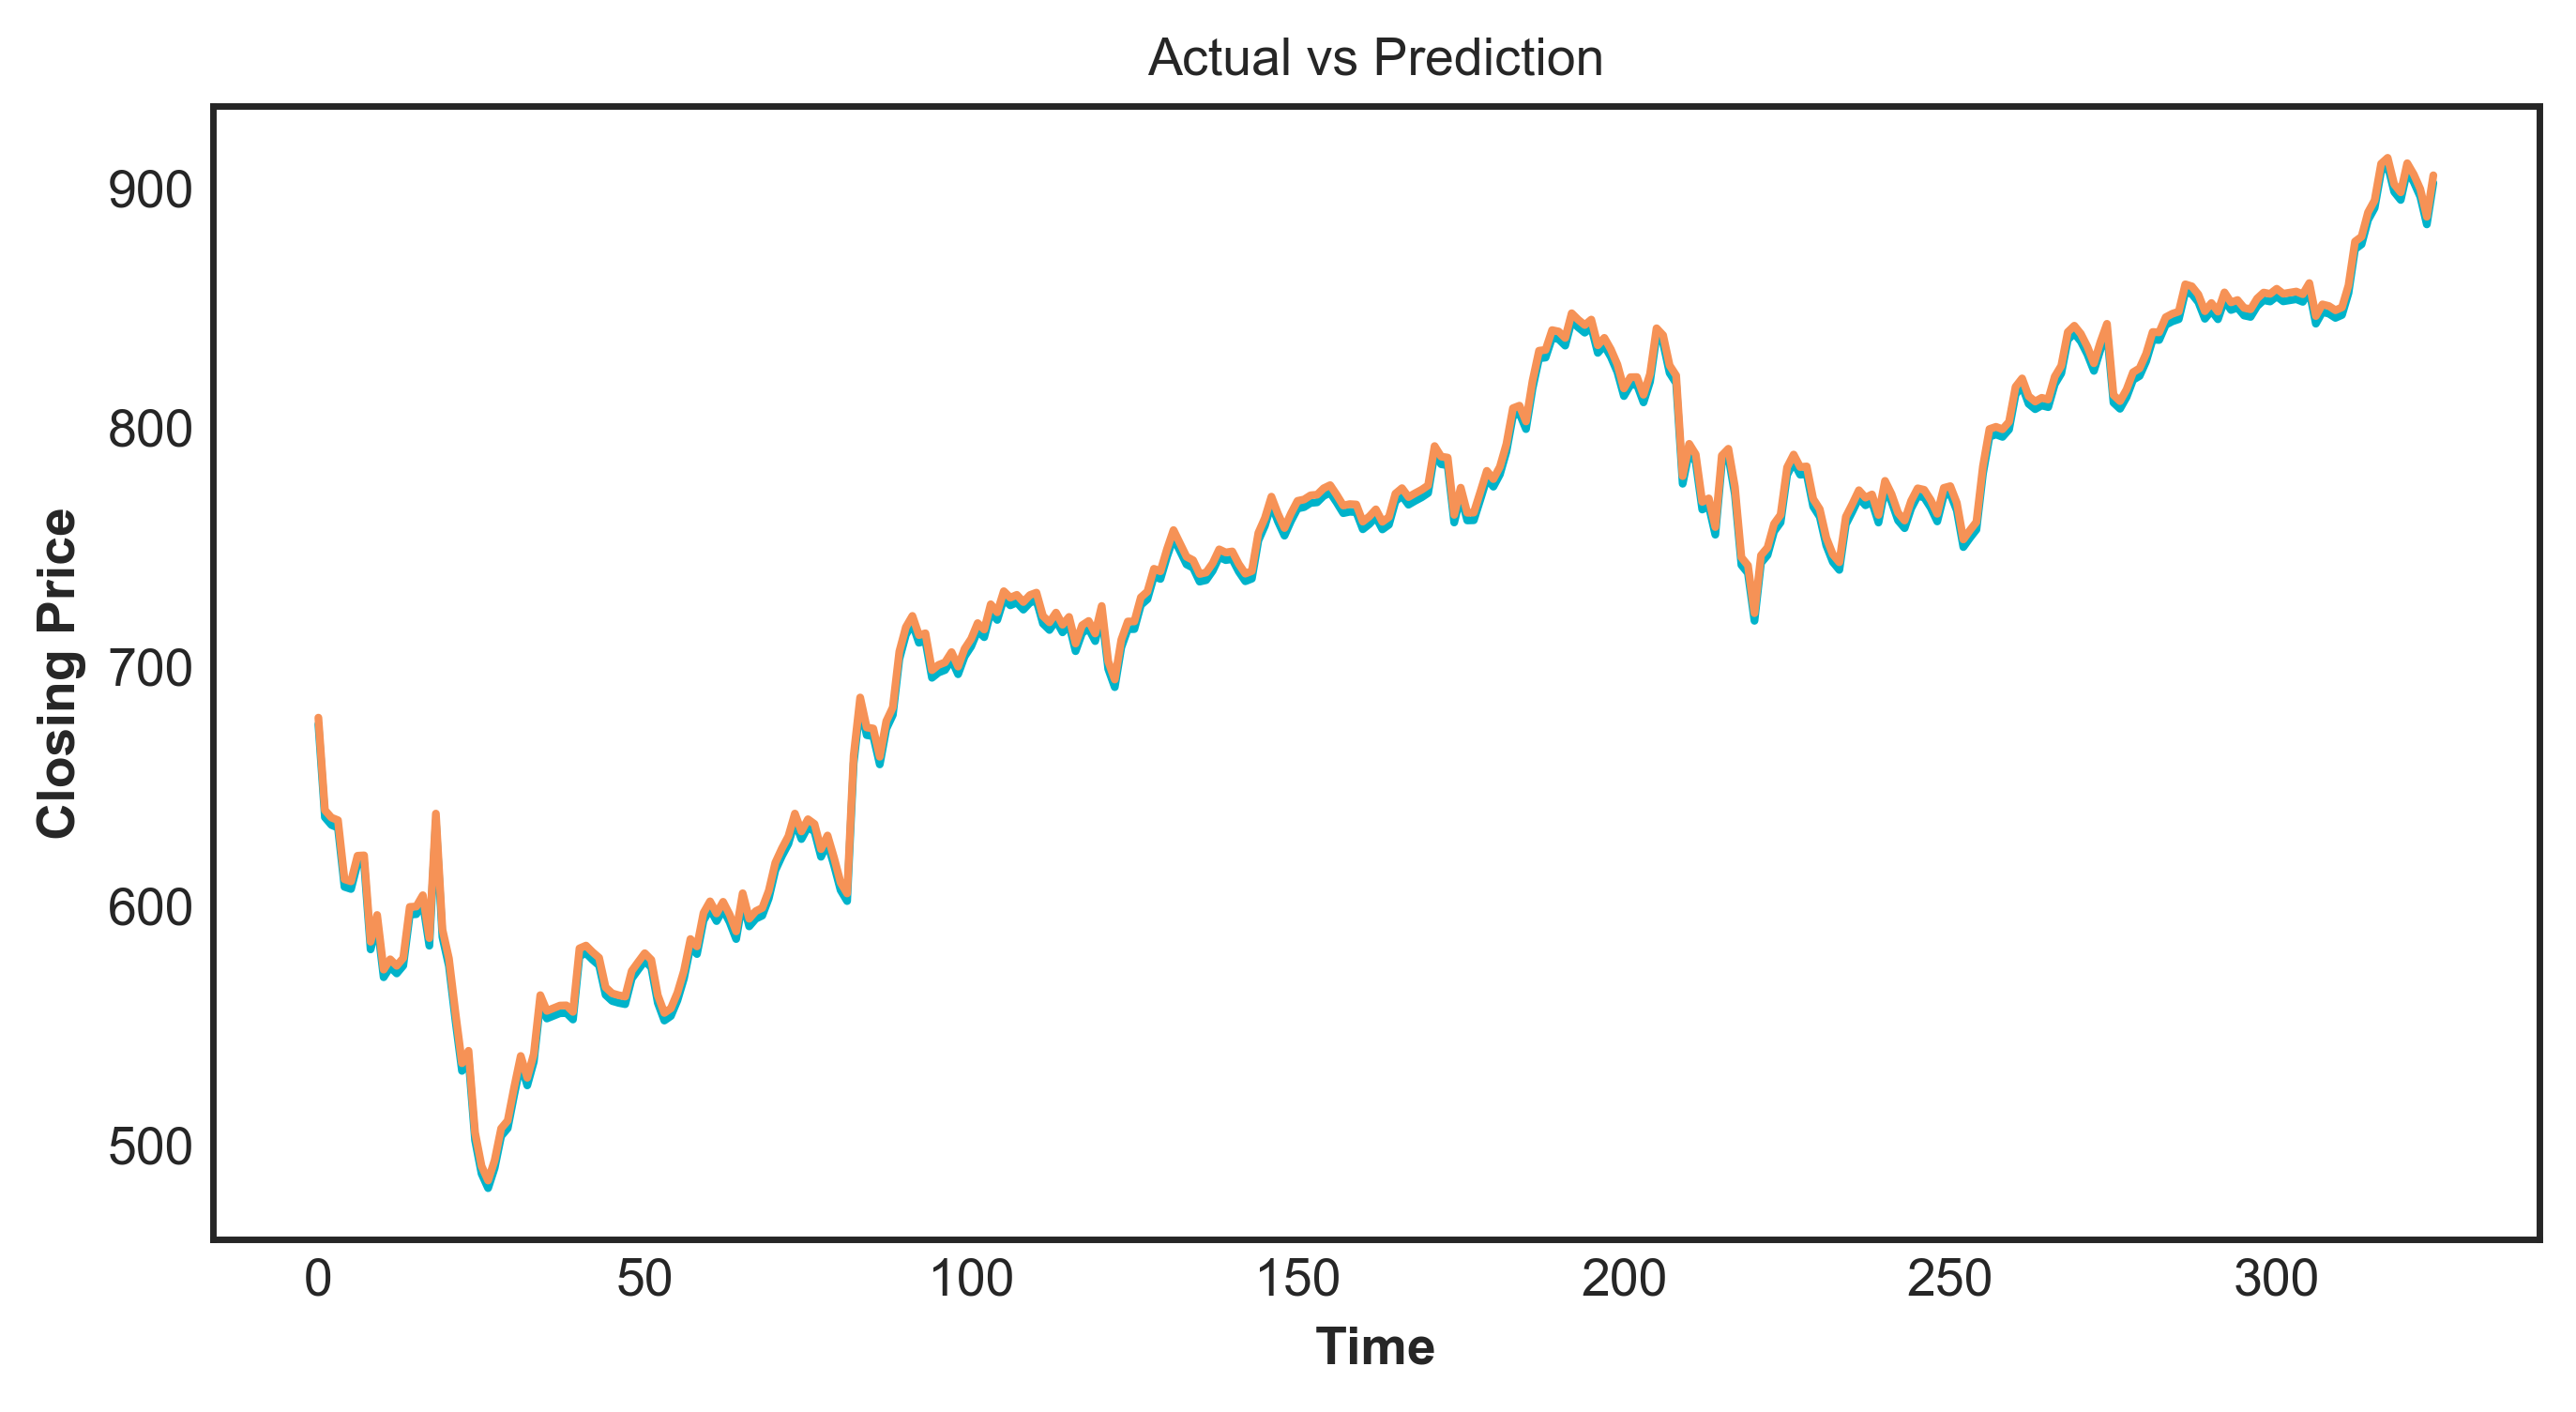

In [87]:
# training_predictions = np.concatenate((np.full((num_lags, 1), training_predictions[0]), training_predictions))
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.4)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction')
plt.plot(stocks[0].iloc[:training_size, :].values, color = "#00b3ca", label='Actual')
plt.plot(training_predictions, color = "#f69256", label='Prediction')
plt.show()

## Test Outcome

In [89]:
test_predictions = new_model.predict(test_input, batch_size=new_batch_size)
test_predictions = scalers[0].inverse_transform(test_predictions)

for i in range(training_size, len(df)+1):
    test_predictions[i-training_size][0] += stocks[0].iloc[i:i+1,:].values[0][0]

rmse = sqrt(mean_squared_error(stocks[0].iloc[training_size+1:, :].values, test_predictions[:-1]))
print('Test RMSE: %.4f' % rmse)

Test RMSE: 15.1158


In [ ]:
# test_predictions = np.concatenate((np.full((num_lags, 1), test_predictions[0]), test_predictions))
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.4)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.plot(stocks[0].iloc[training_size+1:, :].values, color = "#00b3ca",label='Actual')
plt.plot(test_predictions, color = "#f69256", label='Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction for Unseen Data')
plt.show()

## Forecasted Price

3/11/2017 is the day we bought the stocks, while 6/11/2017 is the day after the weekend where we predict a rise in price.

In [91]:
print("Closing Price 3/11/2017")
print(stocks[0].iloc[-1:,:1].values[0][0])
print('\n')
print("Predicted Closing Price on 6/11/2017")
print(test_predictions[-1][0])

Closing Price 3/11/2017
1111.599976


Predicted Closing Price on 6/11/2017
1114.79
